In [6]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import time      as clock
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [8]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None # 5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'dmoc'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'dflux'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None # 
ref_name  = None #'TKE, ck=0.1' # None #
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2
which_dpi = 300
do_rescale= None #'log10'
proj      = 'pc'
do_contour= True
which_isopyc = 36.72
do_plot   = 'tcf'
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]

In [9]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if (ref_path is not None) and (ref_path is not "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path is not "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        
    
#______________________________________________________________________________________________________        
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]


 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [10]:
#___LOAD FESOM2 DATA___________________________________________________________________________________    
# load divergence of density class
ts = clock.time()
data_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    data_list.append( tpv.load_dmoc_data(mesh, datapath, descript, year, 'srf', std_dens, do_dflx=True, do_info=False) ) 
print(' --> elapsed time: {} min'.format((clock.time()-ts)/60))        
ts = clock.time()

#___COMPUTE DIAPYCNAL VERTICAL VELOCITY________________________________________________________________
# finds closest index of isopycnal class
ndens       = len(std_dens)
idx_isopycn = np.argmin(np.abs(np.array(std_dens)-which_isopyc))
print(' sigma_2 = {:5.2f} kg/m^3'.format(std_dens[idx_isopycn]))
# integrate (xr.sum) divergence over all density classes below idx_isopycn     
dflux_list = list()
for ii, data in enumerate(data_list):
    dflux = -data.isel(ndens=idx_isopycn).rename({'dmoc_fd':'dflux'}).load()
    dflux[list(dflux.keys())[0]] = dflux[list(dflux.keys())[0]].assign_attrs({'description':'surface buoyancy forced transformations',
                                                                              'long_name'  :'surface buoyancy forced transformations',
                                                                              'short_name' :'surf. forc. transf.',
                                                                              'units'      :'m/s',
                                                                              'str_ldep'   :', $\sigma_{{2}}$={:5.2f}kg/m³'.format(std_dens[idx_isopycn])})
    if (ref_path is not None) and (ref_path is not "None"): 
        if ii == 0: 
            dflux_ref = dflux.copy()
            if do_reffig: dflux_list.append(dflux_ref) 
        else:        
            dflux_list.append( tpv.do_anomaly(dflux, dflux_ref) )
    else:                                                   
        dflux_list.append( dflux )
print(' --> elapsed time: {} min'.format((clock.time()-ts)/60))            

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elapsed time: 0.026944168408711753 min
 sigma_2 = 36.72 kg/m^3
 --> elapsed time: 0.5812192837397258 min


In [11]:
# do regular binning of diapycnal velocities
Rearth     = 6371e3
rad        = np.pi/180
dlon, dlat = 2.0, 2.0
lon_reg    = np.arange(-180, 180+dlon, dlon)
lat_reg    = np.arange( -90,  90+dlat, dlat)
mlon_reg , mlat_reg = (lon_reg[1:]+lon_reg[:-1])/2.0, (lat_reg[1:]+lat_reg[:-1])/2.0
nmlon_reg, nmlat_reg= mlon_reg.size, mlat_reg.size

# computre area of reg grid 
dx, dy = np.pi*Rearth*dlon/180*np.cos(mlat_reg*rad), np.pi*Rearth*dlat/180
area_reg = np.transpose(np.ones((nmlon_reg, nmlat_reg))*dy * dx)

#compute bins 
e_x, e_y = mesh.n_x[mesh.e_i].sum(axis=1)/3.0, mesh.n_y[mesh.e_i].sum(axis=1)/3.0
bin_x, bin_y = np.zeros(len(e_x))-1, np.zeros(len(e_y))-1
for ni in range(nmlon_reg): bin_x[ (e_x-lon_reg[ni])*(e_x-lon_reg[ni+1])<=0 ] = ni
for ni in range(nmlat_reg): bin_y[ (e_y-lat_reg[ni])*(e_y-lat_reg[ni+1])<=0 ] = ni
    
#_______________________________________________________________________________________________________________
bin_dflux_list = list()    
for dflux in dflux_list:
    #___________________________________________________________________________________________________________
    # create xarray dataset
    coords    = {'nlon':(['nlon'], mlon_reg), 'nlat':(['nlat' ], mlat_reg)}    
    varname   = 'bin_dflux'
    var       = {varname:(['nlat', 'nlon'], np.zeros([nmlat_reg, nmlon_reg]), dflux['dflux'].attrs)}
    bin_dflux = xr.Dataset(data_vars=var, coords=coords, attrs=dflux.attrs)
    
    #___________________________________________________________________________________________________________
    # compute binning
    for yi in range(nmlat_reg):
        for xi in range(nmlon_reg):
            idx=((bin_x==xi) & (bin_y==yi))
            if not any(idx): continue
            bin_dflux[varname][yi,xi]=( dflux['dflux'].data[idx]*dflux['w_A'].data[idx] ).sum()/area_reg[yi, xi]
            
    #___________________________________________________________________________________________________________
    # attache to list         
    bin_dflux_list.append(bin_dflux)
    del(bin_dflux)

--> histo: cmin, cmax =  -2.0112661681418795e-06 1.4367472008291134e-06
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -2e-06, 'cmax': 1.4e-06, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fd4f856f690>, 'clevel': array([-2.0e-06, -1.9e-06, -1.8e-06, -1.7e-06, -1.6e-06, -1.5e-06,
       -1.4e-06, -1.3e-06, -1.2e-06, -1.1e-06, -1.0e-06, -9.0e-07,
       -8.0e-07, -7.0e-07, -6.0e-07, -5.0e-07, -4.0e-07, -3.0e-07,
       -2.0e-07, -1.0e-07,  0.0e+00,  1.0e-07,  2.0e-07,  3.0e-07,
        4.0e-07,  5.0e-07,  6.0e-07,  7.0e-07,  8.0e-07,  9.0e-07,
        1.0e-06,  1.1e-06,  1.2e-06,  1.3e-06,  1.4e-06,  1.5e-06])}


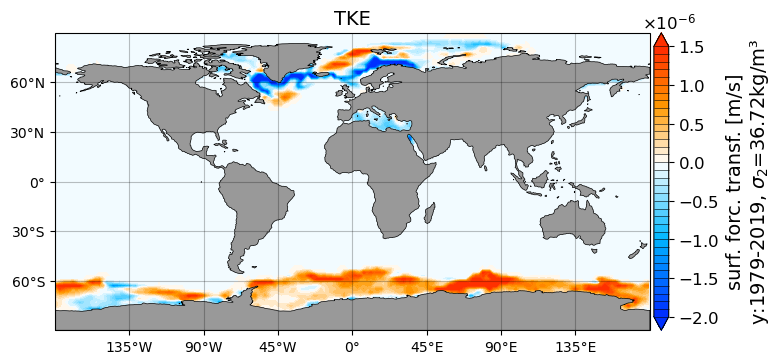

 --> elapsed time: 0.024696075916290285 min


In [12]:
ts = clock.time()
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(dflux_list[0].keys())[0] #vname
slabel = dflux_list[0][sname].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncolumn= np.min([ncolumn,len(dflux_list)])    
nrow   = np.ceil(len(dflux_list)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
# cinfo = dict({'cstr':'blue2red', 'crange':[-1.0e-7, 1.0e-7, 0.0] })
# fig, ax, cbar = tpv.plot_hslice(mesh, dflux_list, cinfo=cinfo, box=box, n_rc=[nrow, ncolumn], 
#                             figsize=[ncolumn*7, nrow*3.5], proj = proj, do_plot=do_plot,  
#                             do_lsmask='fesom', do_rescale=do_rescale, title='descript', 
#                             pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
#                             do_save=spath, save_dpi=which_dpi)
fig, ax, cbar = tpv.plot_hslice_reg(mesh, bin_dflux_list, input_names, box=box, n_rc=[nrow, ncolumn], 
                                    cinfo=cinfo, do_rescale=do_rescale, 
                                    do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale,
                                    figsize=[ncolumn*figfac[0], nrow*figfac[1]], proj = proj, title='descript', 
                                    pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                                    do_save=spath, save_dpi=which_dpi)
print(' --> elapsed time: {} min'.format((clock.time()-ts)/60))            